# Summary

This script is to visualize the embeddings for small groups 

In [1]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spec2vec.vector_operations import calc_vector
from collections import OrderedDict, Counter
import seaborn as sns
from sklearn.manifold import TSNE

RDKit WARNING: [10:18:01] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# Define functions
def compute_and_plot_tsne(embedding_array,label_list,save_path,label_type, num_components=2):
    # compute tsne
    tsne_set = TSNE(n_components=2, random_state=1)
    tsne_res = tsne_set.fit_transform(embedding_array)
    #print(tsne_res)
    tsne_pickle = os.path.join(save_path,'%s_tsne%dD.pickle' % (label_type,num_components))
    pickle.dump(tsne_res, open(tsne_pickle,'wb'))
    # define color
    nice_colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                    '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',   
                    '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000', 
                    '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080','#000000']  # colors for most common and unclassified labels
    tsne_palette = sns.set_palette(sns.color_palette(nice_colours))
    uncl = "Unclassified"
    uncl_other = "Other/Unclassified"
    add_uncl = False
    ori_classes = list(list(zip(*Counter(label_list).most_common()))[0])  # order classes on most occurring
    if uncl in ori_classes:
        add_uncl = True
        ori_classes.remove(uncl)  # remove Unclassified from list
    collapsed_classes = ori_classes[:len(nice_colours)-1]  # keep first 20 classes (or how many in nice colours - 1)
    d_collapsed_classes = {c:c for c in collapsed_classes}  # make into dict to adjust the classes for each spectrum later    
    colour_dict = OrderedDict([(cl,nice_colours[min([i,len(nice_colours)-1])]) for i, cl in enumerate(collapsed_classes)])
    if add_uncl:
        colour_dict[uncl_other] = nice_colours[-1]  # add black colour for other/unclassified
    #print(colour_dict)
    # edit original classes list so each spectrum has collapsed class
    chosen_classes = [d_collapsed_classes.get(c_cl, uncl_other) for c_cl in label_list]
    spectra_chosen_classes = [colour_dict[c_cl] for c_cl in chosen_classes]  # get colour for each spec for matplotlib
    
    # plot tsne
    if num_components == 2:
        
        plt.figure(figsize=(15,9))
        ax = sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=label_list,legend="full") #adjust dot size

        ax.set(xlabel='t-SNE dim 1', ylabel='t-SNE dim 2',
               title=f't-SNE of {len(chosen_classes)} spectral embeddings for {label_type} classes {num_components}D')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        handles, labels = ax.get_legend_handles_labels()
        by_label_unsorted = dict(zip(labels, handles))
        by_label = OrderedDict([(lab,by_label_unsorted[lab]) for lab in colour_dict.keys()])
        ax.legend(by_label.values(), by_label.keys(), loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
        # ax.legend()
        plt.savefig(os.path.join(save_path, f"plot_tsne_{label_type}_2D.svg"))
        plt.show()
    else:
        plt.figure(figsize=(15,9))
        plt.scatter(tsne_3d_w_res[:,0],tsne_3d_w_res[:,1], 0.02, c=spectra_chosen_classes, label=chosen_classes)
        plt.savefig(os.path.join(save_path, f"plot_tsne_{label_type}_3D.svg", dpi=200, bbox_inches='tight'))
        plt.show()

In [3]:
def select_labels(accuracy_dict,min_accuracy, max_accuracy,min_groupsize, max_groupsize):
    label_list = accuracy_dict['labels']
    accuracy_list = accuracy_dict['accuracy']
    groupsize_list = accuracy_dict['group_size']
    
    accu_index = [i for i,v in enumerate(accuracy_list) if v >= min_accuracy and v <= max_accuracy]
    groupsize_index = [i for i,v in enumerate(groupsize_list) if v >= min_groupsize and v <= max_groupsize]
    sel_index = list(set(accu_index) & set(groupsize_index))
    sel_label = [label_list[i] for i in sel_index]
    return sel_label

## Load embedding arrays

In [4]:
## Loading embedding arrays
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv') as file_name:
    X_embedding = np.loadtxt(file_name, delimiter=",")
print(X_embedding.shape)
save_path = '/mnt/scratch/ding013/MS2ChemClass/tsne/'

(16360, 300)


## ClassyFire Classes

In [5]:
## Loading label list
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_class_labels.pickle','rb') as f:
    label_list = pickle.load(f)
## Loading accuracy dict
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_class_lda_min4.pickle','rb') as f:
    lda_accuracy_dict = pickle.load(f)
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_class_randomforest_min4.pickle','rb') as f:
    rf_accuracy_dict = pickle.load(f)

### Inspect all data

### Inspect selected data

#### For labels with low frequency but high accuracy

['Phthalide isoquinolines', 'Tetracyclines', 'Arylnaphthalene lignans', 'Cinchona alkaloids', 'Vinca alkaloids']


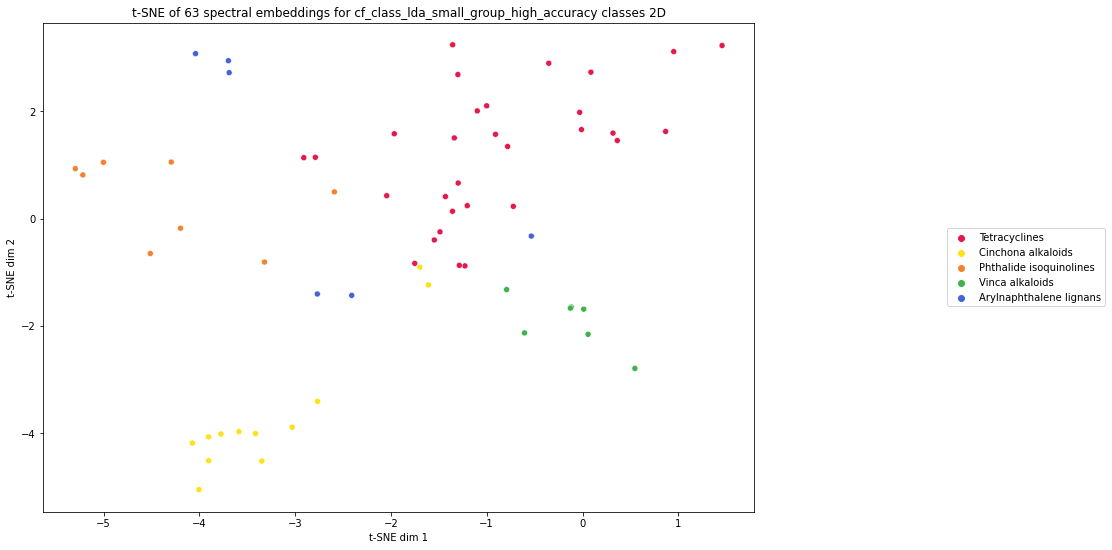

In [6]:
label_type = 'cf_class_lda_small_group_high_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0.8, max_accuracy=1,min_groupsize=0, max_groupsize=30)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

['Phenanthrolines', 'Tetracyclines', 'Macroline alkaloids', 'Cinchona alkaloids', 'Protopine alkaloids', 'Ibogan-type alkaloids', 'Purine nucleotides', 'Oxanes']


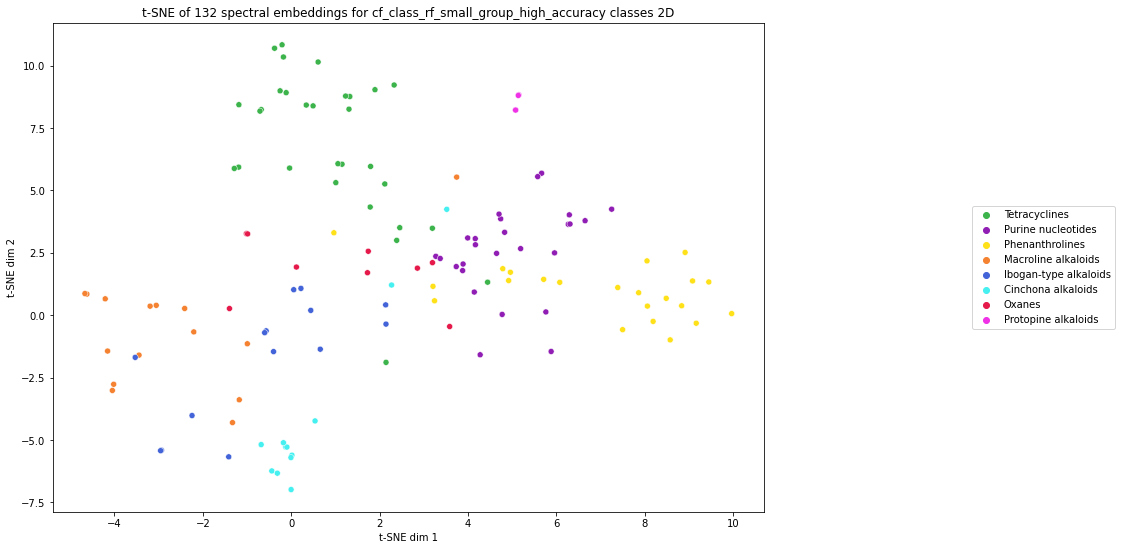

In [7]:
label_type = 'cf_class_rf_small_group_high_accuracy'
accuracy_dict = rf_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0.8, max_accuracy=1,min_groupsize=0, max_groupsize=30)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

#### For labels with high frequency but low accuracy

['Fatty Acyls', 'Flavonoids', 'Steroids and steroid derivatives', 'Carboxylic acids and derivatives', 'Prenol lipids', 'Benzene and substituted derivatives', 'Organooxygen compounds']


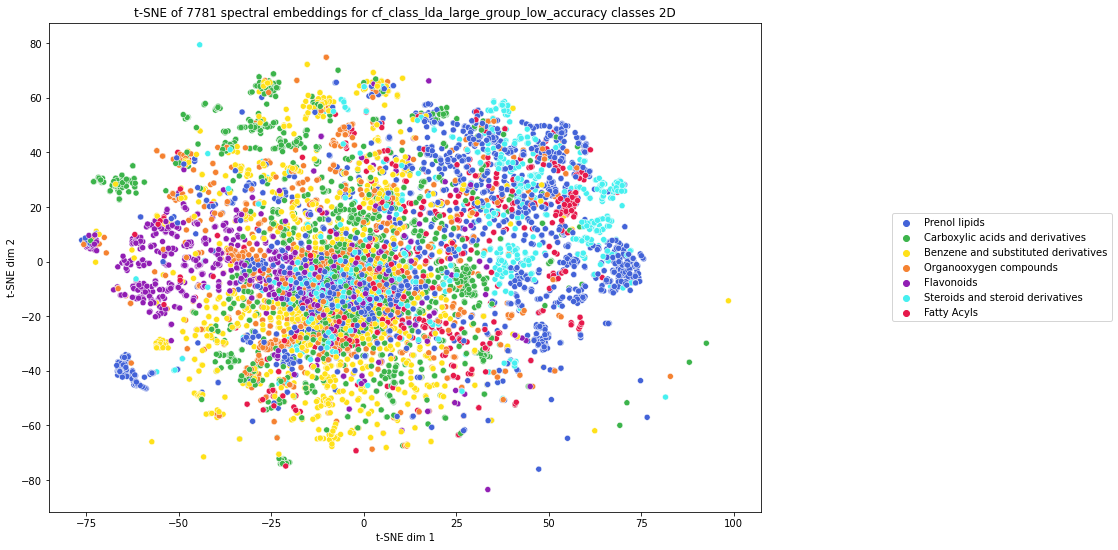

In [8]:
label_type = 'cf_class_lda_large_group_low_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0, max_accuracy=0.7,min_groupsize=500, max_groupsize=20000)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

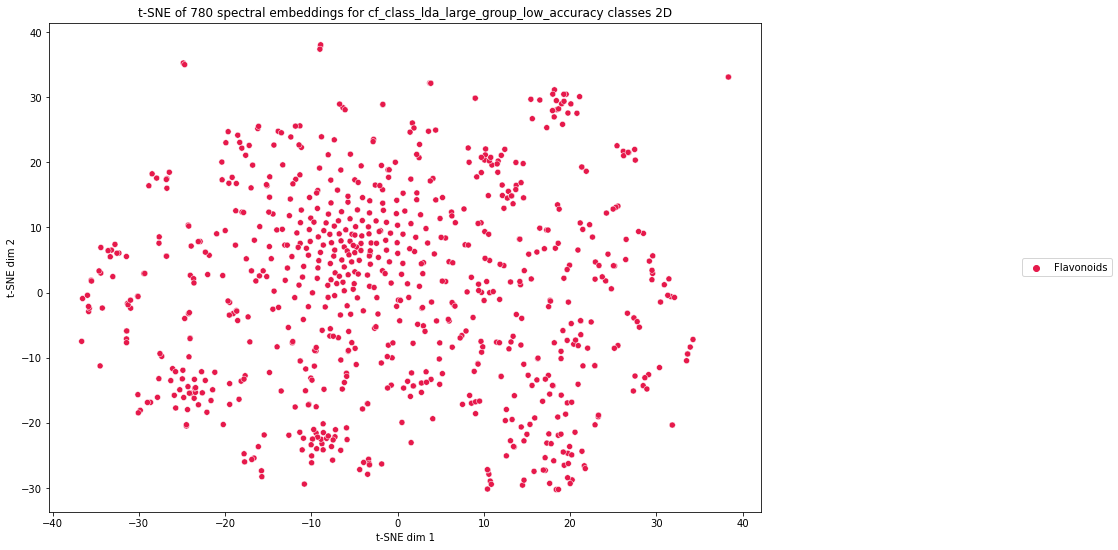

In [9]:
label_type = 'cf_class_lda_large_group_low_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = 'Flavonoids'
sel_index = [i for i,x in enumerate(label_list) if x == sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

['Flavonoids', 'Carboxylic acids and derivatives', 'Prenol lipids', 'Benzene and substituted derivatives', 'Organooxygen compounds']
(6464, 300)
6464


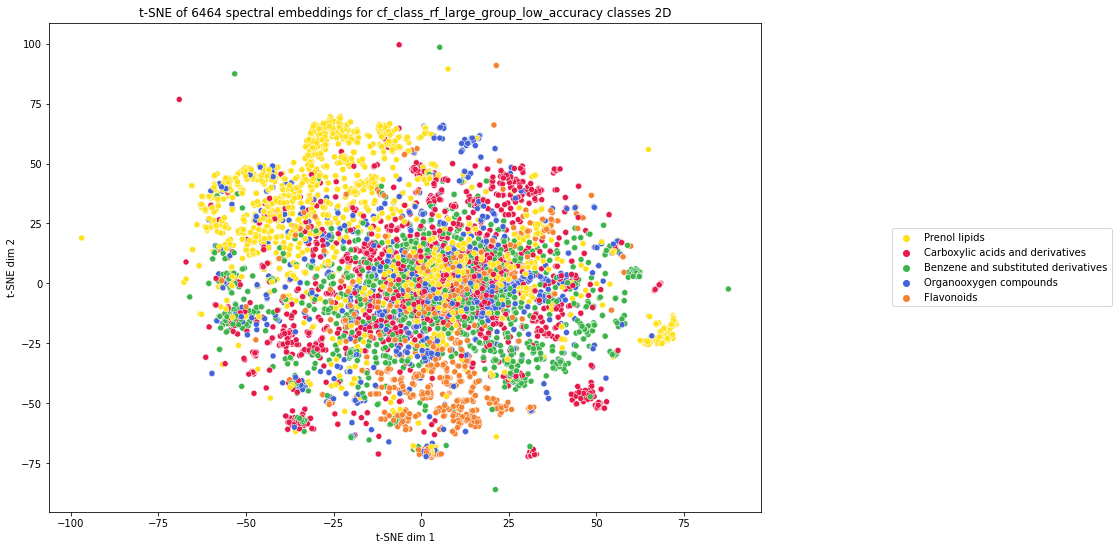

In [10]:
label_type = 'cf_class_rf_large_group_low_accuracy'
accuracy_dict = rf_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0, max_accuracy=0.6,min_groupsize=500, max_groupsize=20000)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
print(embedding_array.shape)
label_list2=[label_list[i] for i in sel_index]
print(len(label_list2))
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

## ClassyFire Subclasses

In [11]:
## Loading label list
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_subclass_labels.pickle','rb') as f:
    label_list = pickle.load(f)
## Loading accuracy dict
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_subclass_lda_min4.pickle','rb') as f:
    lda_accuracy_dict = pickle.load(f)
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_subclass_randomforest_min4.pickle','rb') as f:
    rf_accuracy_dict = pickle.load(f)

#### Inspect all data

#### For labels with low frequency but high accuracy

['1-benzothiopyrans', 'Phenylbutylamines', 'Sulfinylbenzimidazoles', 'Cyclic purine nucleotides', 'Cyclohexylphenols', 'Indoloquinolines', 'Beta lactams', 'Thiophosphoric acid esters', 'Dibenzodiazepines', 'Porphyrins', 'Rotenoids', 'Peptoid-peptide hybrids', 'Purine ribonucleotides']


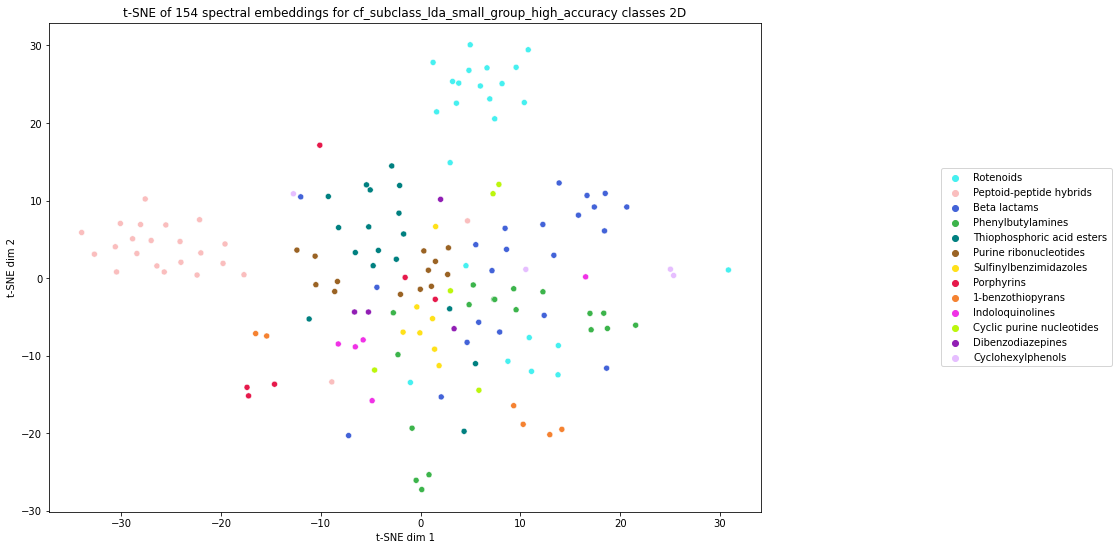

In [12]:
label_type = 'cf_subclass_lda_small_group_high_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0.8, max_accuracy=1,min_groupsize=0, max_groupsize=30)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

['Cinnamic acid esters', 'Acetophenones', 'Benzylamines', 'Cyclohexylphenols', 'Phenylpyridines', 'Benzylpiperidines', 'Aminoquinolines and derivatives', 'Isoindoles', 'Rotenoids', 'Peptoid-peptide hybrids', 'Pheniramines', 'Ceramides', 'Purine ribonucleotides']


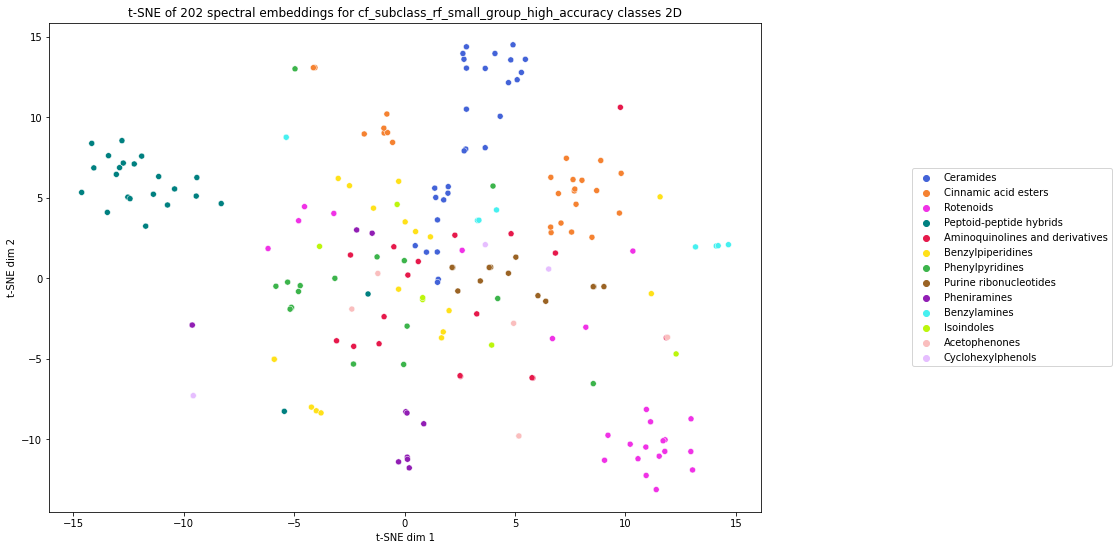

In [13]:
label_type = 'cf_subclass_rf_small_group_high_accuracy'
accuracy_dict = rf_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0.8, max_accuracy=1,min_groupsize=0, max_groupsize=30)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

#### For labels with high frequency but low accuracy

['Amino acids, peptides, and analogues', 'Flavonoid glycosides', 'Carbohydrates and carbohydrate conjugates']


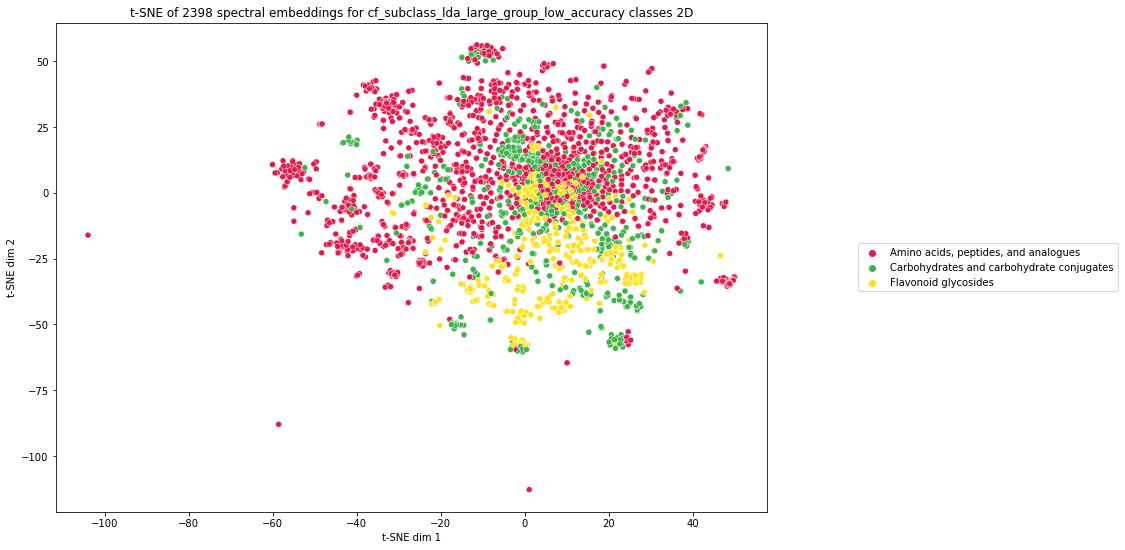

In [14]:
label_type = 'cf_subclass_lda_large_group_low_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0, max_accuracy=0.7,min_groupsize=400, max_groupsize=20000)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

['Amino acids, peptides, and analogues', 'Terpene glycosides', 'Flavonoid glycosides', 'Carbohydrates and carbohydrate conjugates']


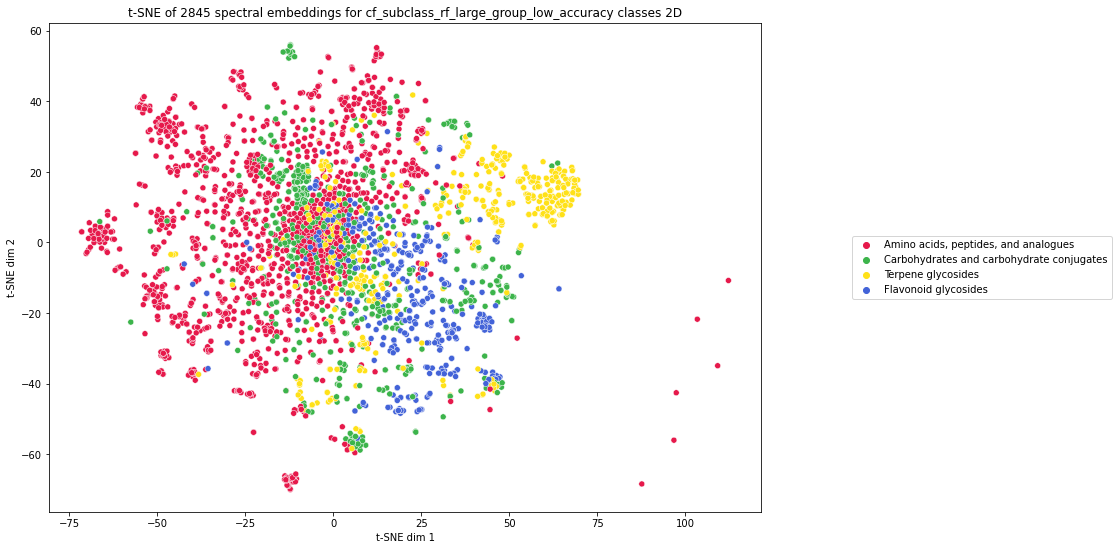

In [15]:
label_type = 'cf_subclass_rf_large_group_low_accuracy'
accuracy_dict = rf_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0, max_accuracy=0.6,min_groupsize=400, max_groupsize=20000)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

## ClassyFire Superclasses

In [16]:
## Loading label list
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_superclass_labels.pickle','rb') as f:
    label_list = pickle.load(f)
## Loading accuracy dict
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_superclass_lda_min4.pickle','rb') as f:
    lda_accuracy_dict = pickle.load(f)
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_superclass_randomforest_min4.pickle','rb') as f:
    rf_accuracy_dict = pickle.load(f)

### Inspect all data

### Inspect selected data

#### For labels with low frequency but high accuracy

['Hydrocarbon derivatives']


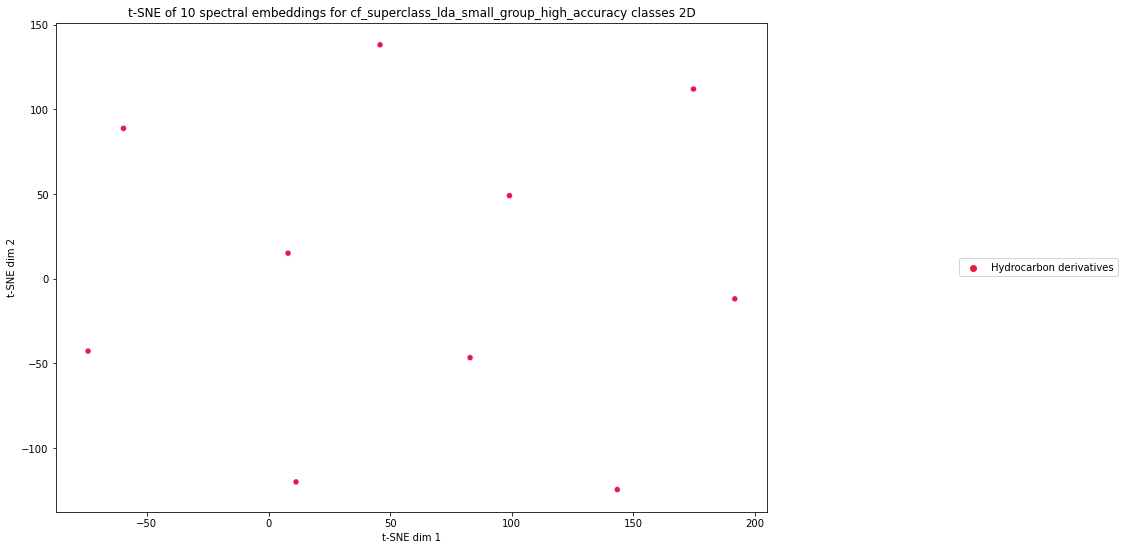

In [17]:
label_type = 'cf_superclass_lda_small_group_high_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0.5, max_accuracy=1,min_groupsize=0, max_groupsize=200)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

['Organic Polymers']


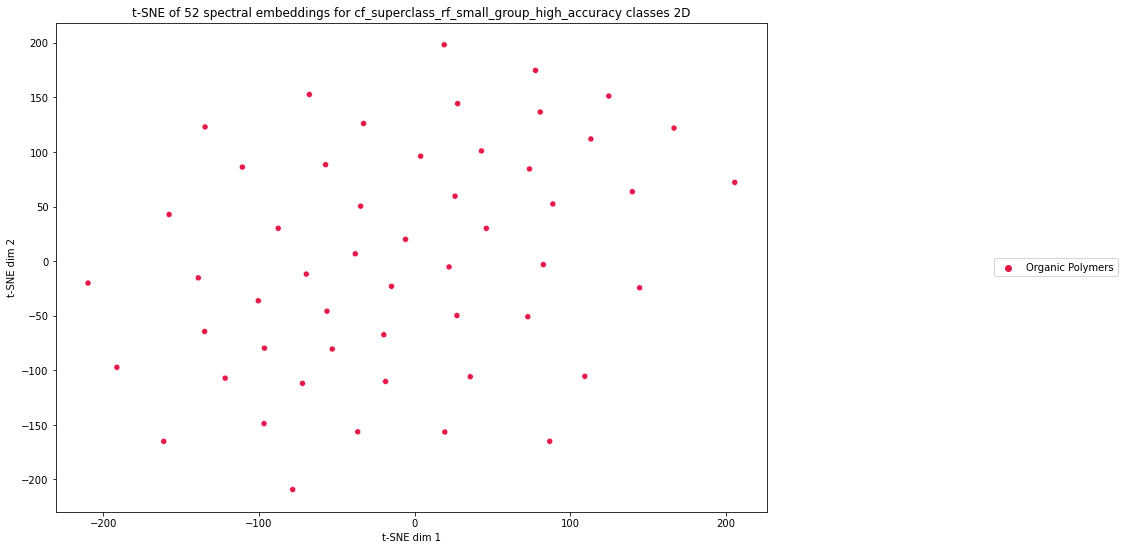

In [18]:
label_type = 'cf_superclass_rf_small_group_high_accuracy'
accuracy_dict = rf_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0.8, max_accuracy=1,min_groupsize=0, max_groupsize=200)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

#### For labels with high frequency but low accuracy

['Benzenoids', 'Organic acids and derivatives', 'Organic oxygen compounds', 'Organoheterocyclic compounds', 'Phenylpropanoids and polyketides']


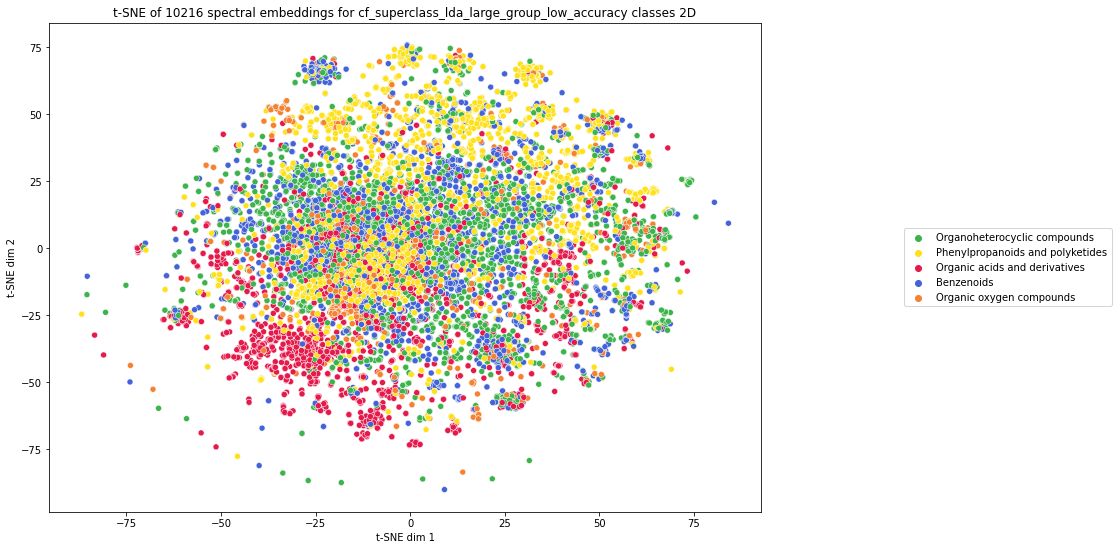

In [19]:
label_type = 'cf_superclass_lda_large_group_low_accuracy'
accuracy_dict = lda_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0, max_accuracy=0.7,min_groupsize=900, max_groupsize=20000)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
label_list2=[label_list[i] for i in sel_index]
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

['Phenylpropanoids and polyketides', 'Benzenoids', 'Organoheterocyclic compounds', 'Lipids and lipid-like molecules']
(10855, 300)
10855


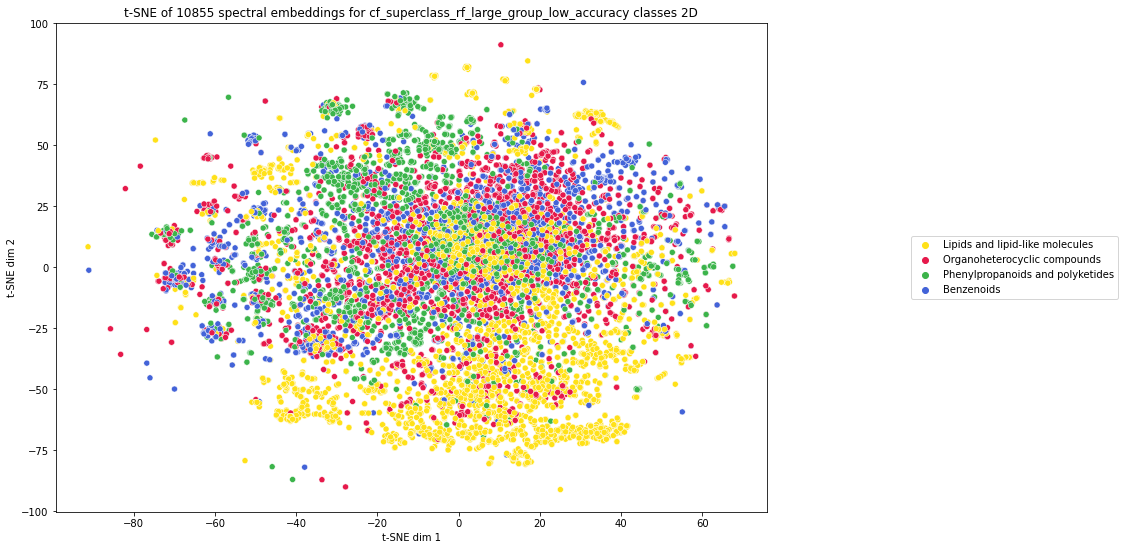

In [20]:
label_type = 'cf_superclass_rf_large_group_low_accuracy'
accuracy_dict = rf_accuracy_dict
sel_label = select_labels(accuracy_dict,min_accuracy=0, max_accuracy=0.6,min_groupsize=500, max_groupsize=20000)
print(sel_label)
sel_index = [i for i,x in enumerate(label_list) if x in sel_label]
embedding_array = X_embedding[sel_index,:]
print(embedding_array.shape)
label_list2=[label_list[i] for i in sel_index]
print(len(label_list2))
compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=2)
#compute_and_plot_tsne(embedding_array,label_list2,save_path,label_type, num_components=3)

## NPClassyfire Classes

#### Inspect all data

#### For labels with low frequency but high accuracy

#### For labels with high frequency but low accuracy

## NPClassyfire Subclasses

#### Inspect all data

#### For labels with low frequency but high accuracy

#### For labels with high frequency but low accuracy

## NPClassyfire Superclasses

#### Inspect all data

#### For labels with low frequency but high accuracy

#### For labels with high frequency but low accuracy